## Important parameters
<br>xt_ocean: longitude, length 3600
<br>yt_ocean: latitude, length 1500
<br> [mind map](https://miro.com/app/board/o9J_lM4N1Pg=/?fromRedirect=1)

In [1]:
import netCDF4 as nc4
import keras
import xarray,numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, add
from keras.layers.core import  Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils
from tensorflow.keras import layers

# Load data

In [2]:
file_path =['C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_01.nc']
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_02.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_03.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_04.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_05.nc')
file_path.append('C:/Users/myxll/OneDrive - The University of Melbourne/capstone/data/OFAM_2017/ocean_eta_t/ocean_eta_t_2000_06.nc')
ds = nc4.MFDataset(file_path)
eta_t = ds.variables['eta_t'][:]
eta_t_numpy = np.array(eta_t)
eta_t_numpy = np.nan_to_num(eta_t_numpy)

# check input shape
eta_t_numpy.shape

(182, 1500, 3600)

# Preprocessing

In [9]:
def fix_missing_value(input_data):
    """
    fixed missing values with 0
    """
    for i in range(0,len(input_data)):
        arr = input_data[i]
        arr[arr == -32768] = 0

In [14]:
def normalize_matrix(matrix):
    """
    Normalize the input
    
    """
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix

In [36]:
import math
lat = 128 # chunk size
long = 128 # chunk size
def split_array(input_data, lat, long):
    """
    Split the whole 3600*1500 array into smaller chunks.
    Padding with zeros to make the array be divisible by chunk size.
    
    Args:
        input_data: data of a single day from a eta_t instance
        lat: chunk size
        long: chunk size
    """
    pad_cols = math.ceil(3600/long)*long - 3600 # number of zero columns adding to the right
    pad_rows = math.ceil(1500/lat)*lat - 1500 # number of zero rows adding to the bottom
    

    input_data=np.pad(input_data,((0,pad_rows),(0,pad_cols)), 'constant',constant_values=(0,0)) # padding with zeros, right & bottom
    
    l = np.array_split(input_data,len(input_data)/lat,axis=0)
    input_data_split = []
    for i in range(len(l)):
        dd = np.array_split(l[i],len(input_data[0])/long,axis=1)
        input_data_split += dd
    input_data_split = np.array(input_data_split)
    return input_data_split

In [41]:
def preprocess(eta_t_numpy, lat, long, region_index): 
    """
    Input a eta_t instance, return a particular region in the splitted array.
    
    Args:
        eta_t_numpy: one eta_t instance in numpy format
        lag: chunk size
        long: chunk size
        region_index: the particular region interested
    Return:
        A numpy array in shape (size, lat, long)
    """
    input_data_split = []
    for i in range(len(eta_t_numpy)):
        input_data = eta_t_numpy[i,:,:]
        fix_missing_value(input_data) # replace missing value

        normalize_matrix(input_data) # normalize

        input_data_split.append(split_array(input_data, lat, long)[region_index])
    return np.array(input_data_split)

In [38]:
input_data_split= preprocess(eta_t_numpy, lat, long, 100)

In [42]:
# save to a file
np.save('128x128_6months',input_data_split)

In [43]:
input_data_split.shape

(182, 128, 128)

In [39]:
input_data_split[0]

array([[0.12207404, 0.09155553, 0.12207404, ..., 0.27466658, 0.24414808,
        0.24414808],
       [0.09155553, 0.09155553, 0.09155553, ..., 0.27466658, 0.27466658,
        0.27466658],
       [0.09155553, 0.09155553, 0.09155553, ..., 0.27466658, 0.27466658,
        0.27466658],
       ...,
       [0.5188147 , 0.5188147 , 0.5188147 , ..., 0.5188147 , 0.48829615,
        0.48829615],
       [0.5188147 , 0.5188147 , 0.5188147 , ..., 0.5188147 , 0.48829615,
        0.48829615],
       [0.5188147 , 0.5188147 , 0.5188147 , ..., 0.5188147 , 0.48829615,
        0.48829615]], dtype=float32)

# split train set & validation set

In [44]:
train_set, test_set = train_test_split(input_data_split, test_size=0.33)
train_set.shape

(121, 128, 128)

# Autoencoder

In [45]:
lat = 128 # chunk size
long = 128 # chunk size

input_img = keras.Input(shape=(lat, long,1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu',strides=(1,1), padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((4, 4))(x)
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 8)         584       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 16)        1168  

In [13]:
history = autoencoder.fit(train_set, train_set,
                epochs=100, validation_data=(test_set, test_set))

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 0.0350 - val_loss: 0.0315
Epoch 2/100
4/4 [==============================] - 2s 424ms/step - loss: 0.0315 - val_loss: 0.0288
Epoch 3/100
4/4 [==============================] - 2s 418ms/step - loss: 0.0288 - val_loss: 0.0280
Epoch 4/100
4/4 [==============================] - 2s 534ms/step - loss: 0.0280 - val_loss: 0.0270
Epoch 5/100
4/4 [==============================] - 2s 567ms/step - loss: 0.0267 - val_loss: 0.0254
Epoch 6/100
4/4 [==============================] - 3s 780ms/step - loss: 0.0254 - val_loss: 0.0238
Epoch 7/100
4/4 [==============================] - 2s 489ms/step - loss: 0.0235 - val_loss: 0.0211
Epoch 8/100
4/4 [==============================] - 2s 483ms/step - loss: 0.0205 - val_loss: 0.0175
Epoch 9/100
4/4 [==============================] - 2s 384ms/step - loss: 0.0164 - val_loss: 0.0124
Epoch 10/100
4/4 [==============================] - 1s 409ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 11/100

4/4 [==============================] - 2s 407ms/step - loss: 3.8929e-04 - val_loss: 4.2451e-04
Epoch 80/100
4/4 [==============================] - 2s 497ms/step - loss: 4.0753e-04 - val_loss: 3.8912e-04
Epoch 81/100
4/4 [==============================] - 1s 368ms/step - loss: 3.8598e-04 - val_loss: 3.7685e-04
Epoch 82/100
4/4 [==============================] - 1s 299ms/step - loss: 3.8061e-04 - val_loss: 3.8290e-04
Epoch 83/100
4/4 [==============================] - 1s 356ms/step - loss: 3.7849e-04 - val_loss: 3.7560e-04
Epoch 84/100
4/4 [==============================] - 2s 439ms/step - loss: 3.7912e-04 - val_loss: 3.7262e-04
Epoch 85/100
4/4 [==============================] - 1s 368ms/step - loss: 3.7218e-04 - val_loss: 3.7063e-04
Epoch 86/100
4/4 [==============================] - 1s 387ms/step - loss: 3.7707e-04 - val_loss: 3.7533e-04
Epoch 87/100
4/4 [==============================] - 1s 309ms/step - loss: 3.7405e-04 - val_loss: 3.6871e-04
Epoch 88/100
4/4 [=======================

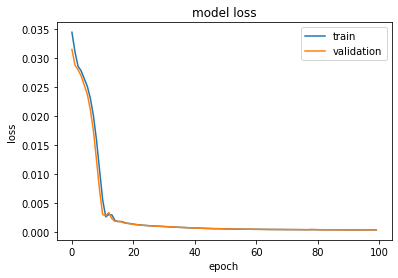

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [19]:
decoded_data = autoencoder.predict(np.array([test_set[10]]))

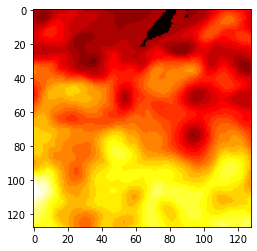

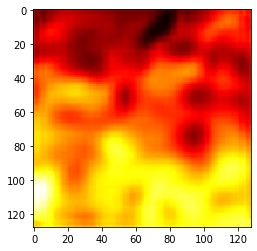

In [21]:
plt.imshow(test_set[10],cmap='hot')
plt.show()
plt.imshow(decoded_data[0,:,:,0],cmap='hot')
plt.show()